<h2>CNN 스팸 메일 분류</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<b>데이터 로드 및 전처리</b>

In [2]:
import urllib.request

In [9]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename = 'spam.csv')
data = pd.read_csv('spam.csv', encoding = 'latin-1')
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [10]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [11]:
data = data[['v1', 'v2']]
data['v1'] = data['v1'].replace(['ham','spam'], [0,1])
data.head(10)

<ipython-input-11-805e9fd7cc17>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['v1'] = data['v1'].replace(['ham','spam'], [0,1])


,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [12]:
data.drop_duplicates(subset = ['v2'], inplace = True)
len(data)

<ipython-input-12-f2362eb90665>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(subset = ['v2'], inplace = True)


5169

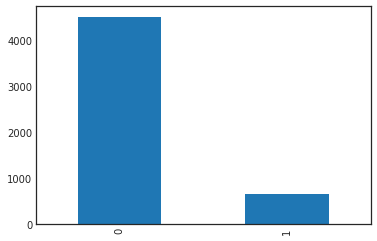

In [14]:
data['v1'].value_counts().plot(kind='bar');

In [15]:
data.groupby('v1').size().reset_index(name = 'count')

,v1,count
0,0,4516
1,1,653


In [16]:
x_data = data['v2']
y_data = data['v1']

In [17]:
vocab_size = 1000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(x_data)
sequences = tokenizer.texts_to_sequences(x_data)
sequences[:2]

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137],
 [49, 306, 435, 6]]

In [21]:
x_data = sequences

print('메일 최대 길이: {}'.format(max(len(l) for l in x_data)))
print('메일 평균 길이: {}'.format((sum(map(len, x_data)) / len(x_data) )))

메일 최대 길이: 172
메일 평균 길이: 12.566840781582512


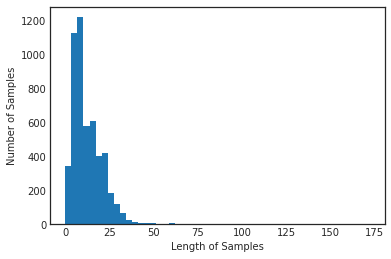

In [22]:
plt.hist([len(s) for s in x_data], bins = 50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [23]:
max_len = 60
data = pad_sequences(x_data, maxlen = max_len)
print(data.shape)

(5169, 60)


In [24]:
n_train = int(len(sequences) * 0.8)
n_test = int(len(sequences) - n_train)

print(n_train)
print(n_test)

4135
1034


In [25]:
x_train = data[:n_train]
y_train = np.array(y_data[:n_train])
x_test = data[n_train:]
y_test = np.array(y_data[n_train:])

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4135, 60)
(4135,)
(1034, 60)
(1034,)


<b>모델 구성</b>

In [28]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5, strides = 1, padding = 'valid', activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [30]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

<b>모델 학습</b>

In [31]:
history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 64,
                   validation_split = 0.2,
                   callbacks = [es, mc])

Epoch 1/10
52/52 [==============================] - 2s 16ms/step - loss: 0.4616 - acc: 0.8691 - val_loss: 0.4013 - val_acc: 0.8730

Epoch 00001: val_acc improved from -inf to 0.87304, saving model to best_model.h5
Epoch 2/10
52/52 [==============================] - 1s 10ms/step - loss: 0.3803 - acc: 0.8697 - val_loss: 0.3615 - val_acc: 0.8730

Epoch 00002: val_acc did not improve from 0.87304
Epoch 3/10
52/52 [==============================] - 1s 13ms/step - loss: 0.2444 - acc: 0.9018 - val_loss: 0.1205 - val_acc: 0.9625

Epoch 00003: val_acc improved from 0.87304 to 0.96252, saving model to best_model.h5
Epoch 4/10
52/52 [==============================] - 0s 9ms/step - loss: 0.0750 - acc: 0.9810 - val_loss: 0.0572 - val_acc: 0.9831

Epoch 00004: val_acc improved from 0.96252 to 0.98307, saving model to best_model.h5
Epoch 5/10
52/52 [==============================] - 0s 9ms/step - loss: 0.0398 - acc: 0.9882 - val_loss: 0.0492 - val_acc: 0.9819

Epoch 00005: val_acc did not improve fro

<b>시각화</b>

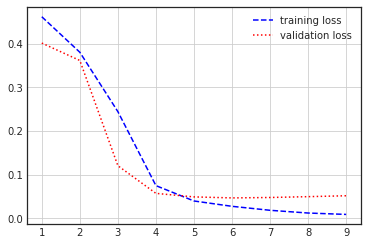

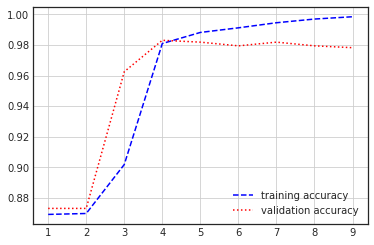

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b--', label = 'training loss')
plt.plot(epochs, val_loss, 'r:', label = 'validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label = 'training accuracy')
plt.plot(epochs, val_acc, 'r:', label = 'validation accuracy')
plt.grid()
plt.legend()

plt.show()

In [35]:
model.evaluate(x_test, y_test)

33/33 [==============================] - 0s 2ms/step - loss: 0.0647 - acc: 0.9797


[0.06472855806350708, 0.9796905517578125]